
# Итоговое домашнее задание по математике МТС ШАД


## Intro

Исследование датасета популярных песен в Spotify в 2023 году. 

Цель исследования: выяснить, влияют ли субъективные характеристики песни (числов битов в секунду, "танцевальность" и т.д.) на ее популярность и могут ли они предскзаать популярность песни. 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df = pd.read_csv('spotify-2023.csv', encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [55]:
#почистила столбец streams от неподходящего значения, чтобы далее перевести в int 
df.drop(df[df['streams'] == 
   'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3'].index,
        axis = 0, inplace = True)
df['streams'] = df['streams'].astype(int)

## Math

Разбиваем данные по группам по колонке 'streams': формируем 4 группы песен по их популярности. Может сказать, что первая группа содержит менее популярные песни среди выборки, четвёртая - более популярные песни. 

### Distribution between samples

In [56]:
q1 = np.quantile(df['streams'], 0.25)
q2 = np.quantile(df['streams'], 0.5)
q3 = np.quantile(df['streams'], 0.75)
q1, q2, q3

(141636175.0, 290530915.0, 673869022.0)

In [63]:
data1 = df[df['streams'] < q1]
data2 = df[np.logical_and(df['streams'] >= q1, df['streams'] < q2)]
data3 = df[np.logical_and(df['streams'] >= q2, df['streams'] <= q3)]
data4 = df[df['streams'] > q3]

In [82]:
from scipy.stats import ks_2samp


ks_statistic, p_value = ks_2samp(data1['bpm'], data2['bpm'])
print("KS Statistic (Vector 1 vs Vector 2):", ks_statistic)
print("P-Value (Vector 1 vs Vector 2):", p_value)

ks_statistic, p_value = ks_2samp(data1['bpm'], data3['bpm'])
print("KS Statistic (Vector 1 vs Vector 3):", ks_statistic)
print("P-Value (Vector 1 vs Vector 3):", p_value)

ks_statistic, p_value = ks_2samp(data1['bpm'], data4['bpm'])
print("KS Statistic (Vector 1 vs Vector 4):", ks_statistic)
print("P-Value (Vector 1 vs Vector 4):", p_value)


KS Statistic (Vector 1 vs Vector 2): 0.07563025210084033
P-Value (Vector 1 vs Vector 2): 0.5048910614088672
KS Statistic (Vector 1 vs Vector 3): 0.08823529411764706
P-Value (Vector 1 vs Vector 3): 0.3128380506457682
KS Statistic (Vector 1 vs Vector 4): 0.08403361344537816
P-Value (Vector 1 vs Vector 4): 0.3707131367768906


В тесте Колмогорова-Смирнова p-value является вероятностью того, что выборки из одного распределения. 
При сравнении первой выборки со всеми остальными p-value намного больше 0.05, что говорит о том, что выборки не из разных распределений. 

Text(0.5, 1.0, 'most streamed')

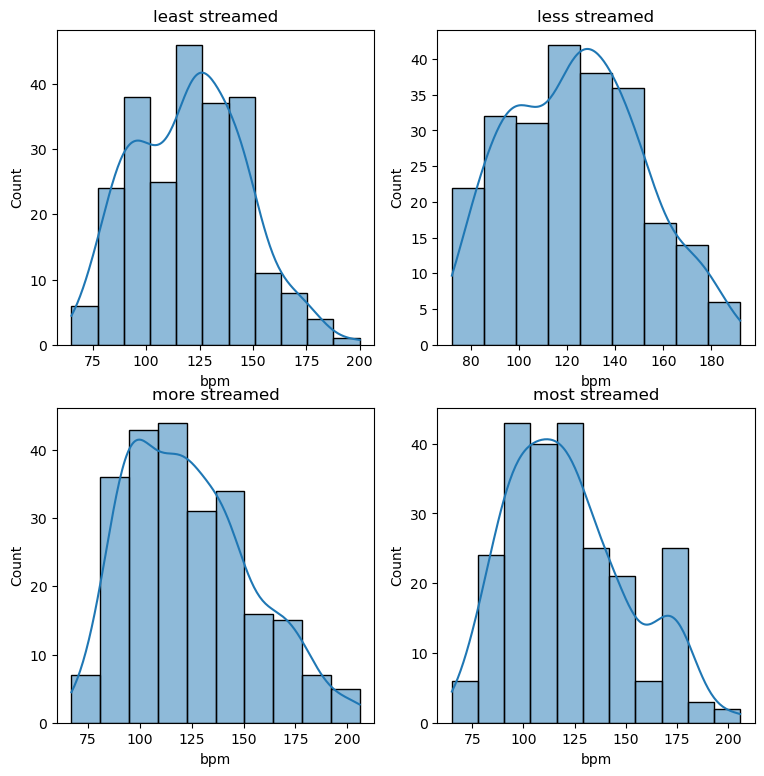

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

sns.histplot(data1['bpm'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('least streamed')
sns.histplot(data2['bpm'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('less streamed')
sns.histplot(data3['bpm'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('more streamed')
sns.histplot(data4['bpm'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('most streamed')

Проверим, одинаковые ли распределения по признаку energy. Для этого можно поочередно сравнивать выборки с помощью индекса PSI, чтобы отследить изменения между выборками попарно. 

In [93]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10):
    def psi(expected_array, actual_array):
        expected_prop = (expected_array + 1e-10) / sum(expected_array)
        actual_prop = (actual_array + 1e-10) / sum(actual_array)
        psi_val = sum((actual_prop - expected_prop) * np.log(actual_prop / expected_prop))
        return psi_val

    expected_bins = np.histogram(expected, bins=buckets)[0]
    actual_bins = np.histogram(actual, bins=buckets)[0]
    return psi(expected_bins, actual_bins)

In [99]:
psi_value = calculate_psi(data1['energy_%'], data2['energy_%'], buckettype='bins', buckets=10)
print("PSI Value between data 1 and 2:", psi_value)

psi_value = calculate_psi(data2['energy_%'], data3['energy_%'], buckettype='bins', buckets=10)
print("PSI Value between data 2 and 3:", psi_value)

psi_value = calculate_psi(data3['energy_%'], data4['energy_%'], buckettype='bins', buckets=10)
print("PSI Value between data 3 and 4:", psi_value)

psi_value = calculate_psi(data1['energy_%'], data4['energy_%'], buckettype='bins', buckets=10)
print("PSI Value between data 1 and 4:", psi_value)

PSI Value between data 1 and 2: 0.05565813237286732
PSI Value between data 2 and 3: 0.06021102687951431
PSI Value between data 3 and 4: 0.07333036672210165
PSI Value between data 1 and 4: 0.23992005887889492


__Интерпретировать результаты PSI можно так:__

Различия между выборками несущественны, так как PSI < 0.1; Но между 1 и 4 выборками есть различие (не особо существенное). С такими данными можно работать, но возможно модель не так хорошо будет себя показывать. 

__Теперь визуально посмотрим на распределение между выборками значения "valence"__

Valence в музыке означает позитивность песни, субъективное измерение хорошего, радостного настроения, которое передается через мелодию и слова песни.

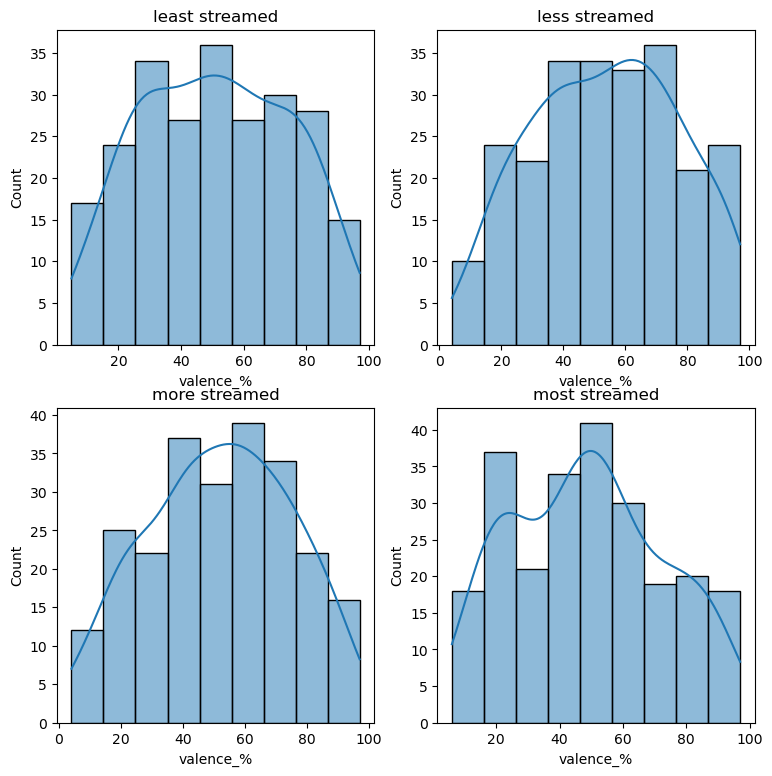

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

sns.histplot(data1['valence_%'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('least streamed')
sns.histplot(data2['valence_%'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('less streamed')
sns.histplot(data3['valence_%'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('more streamed')
sns.histplot(data4['valence_%'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('most streamed')
plt.show()

Визуально между собой схожи распределения выборок 1, 2, 3. Четвёртая выборка сильно отличается по распределению. 

Заметен выброс в 4 выборке со стороны песен с маленьким valence. Пользователи стриминга "заслушивают" достаточно много грустных песен. 

### Hypothesis testing

__Гипотеза 1.__ 
H0: Средняя __"танцевальность" (danceability)__  в группах одинакова. 

H1: Есть существенная разница между средней танцевальностью треков в выборках.

Значение: слушатели могут поднимать в топы чартов более танцевальные треки. 

In [136]:
dance1 = data1['danceability_%']
dance2 = data2['danceability_%']
dance3 = data3['danceability_%']
dance4 = data4['danceability_%']

# ANOVA
def anova(s1, s2, s3, s4):
    statistic, p_value = f_oneway(s1, s2, s3, s4)

    alpha = 0.05
    if p_value < alpha:
        print("Нулевая гипотеза отвергается. Есть статистически значимая разница")
    else:
        print("Нулевая гипотеза не отвергается. Нет статистически значимой разницы")

    print("p-value:", p_value)

anova(dance1, dance2, dance3, dance4)

Нулевая гипотеза отвергается. Есть статистически значимая разница
p-value: 0.02040789630418595


Итог тестирования: в выборках разные треки по признаку танцевальности. Значит, танцевальные треки могут быть более популярными. 

Стало интересно: а есть ли зависимость между двумя самыми популярными выборками, между самой популярной и самой непопулярной?
Новые гипотезы:

__Гипотеза 1.1__
Н0: Нет различия в средней танцевальности в выборках 3 и 4.

Н1: В выборках 3 и 4 разная средняя танцевальность песни. 


In [138]:

def anova2(s1, s2):
    statistic, p_value = f_oneway(s1, s2)

    alpha = 0.05
    if p_value < alpha:
        print("Нулевая гипотеза отвергается. Есть статистически значимая разница")
    else:
        print("Нулевая гипотеза не отвергается. Нет статистически значимой разницы")

    print("p-value:", p_value)
    
anova2(dance1, dance2)

Нулевая гипотеза не отвергается. Нет статистически значимой разницы
p-value: 0.3839623810886498


Вывод: в выборках 3 и 4 схожая средняя танцевальность песен. 

__Гипотеза 1.2__
Н0: Нет различия в танцевальности в выборках 1 и 4.

Н1:  В выборках 1 и 4 разная средняя танцевальность песни. 

In [139]:
anova2(dance1, dance4)

Нулевая гипотеза отвергается. Есть статистически значимая разница
p-value: 0.0322504979878213


Вывод: в выборках 1 и 4 различная средняя танцевальность песен. 

В итоге тестирования гипотезы 1 можно предположить, что более танцевальные треки пользуются большей популярностью. 

__Гипотеза 2.__ 
H0: Среднее значение Liveness одинаково во всех группах квантилей по стримам.

H1: Существуют различия в значениях Liveness между группами квантилей.

Значение: пользователи могут любить треки, где превалирует живое выступление или наоборот. 

In [140]:
liveness1 = data1['liveness_%']
liveness2 = data2['liveness_%']
liveness3 = data3['liveness_%']
liveness4 = data4['liveness_%']

anova(liveness1, liveness2, liveness3, liveness4)

Нулевая гипотеза не отвергается. Нет статистически значимой разницы
p-value: 0.5640740266326478


Нулевая гипотеза не отвергается, значит во всех выборках примерно одинаковое среднее количество элементов живого выступления в треках. 

__Интервальная оценка разницы между группами__

In [149]:
# функция оценки бутстрепом
def bootstrap_diff(data1, data2, num_samples=1000):
    diffs = []
    for _ in range(num_samples):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diff = np.mean(sample1) - np.mean(sample2)
        diffs.append(diff)
    
    diff_mean = np.mean(diffs)
    confidence_interval = np.percentile(diffs, [2.5, 97.5])
    
    return diff_mean, confidence_interval

Mean Difference: -1.1360168067226892
Confidence Interval: [-3.5677521   1.43739496]


__Для первой гипотезы:__

In [151]:
group1 = data1['danceability_%']
group2 = data2['danceability_%']
group3 = data3['danceability_%']
group4 = data4['danceability_%']

In [159]:
diff_mean, conf_interval = bootstrap_diff(group1, group2)
print("Оценка разницы между группами 1 и 2:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')


diff_mean, conf_interval = bootstrap_diff(group2, group3)
print("Оценка разницы между группами 2 и 3:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')

diff_mean, conf_interval = bootstrap_diff(group3, group4)
print("Оценка разницы между группами 3 и 4:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')

diff_mean, conf_interval = bootstrap_diff(group1, group4)
print("Оценка разницы между группами 1 и 4:", diff_mean)
print("Доверительный интервал:", conf_interval)

Оценка разницы между группами 1 и 2: -1.1840672268907566
Доверительный интервал: [-3.66817227  1.40063025]

Оценка разницы между группами 2 и 3: 1.3810420168067226
Доверительный интервал: [-1.50052521  4.2230042 ]

Оценка разницы между группами 3 и 4: 2.6182436974789915
Доверительный интервал: [-0.07363445  5.19380252]

Оценка разницы между группами 1 и 4: 2.823415966386555
Доверительный интервал: [0.11764706 5.42867647]


__Вывод:__ с ростом популярности треки становятся более танцевальными (в среднем). При этом между группами 1 и 2 отрицательная разница. 

__Гипотеза:__ Чем популярнее песня, тем больше она отвечает параметру танцевальности. 

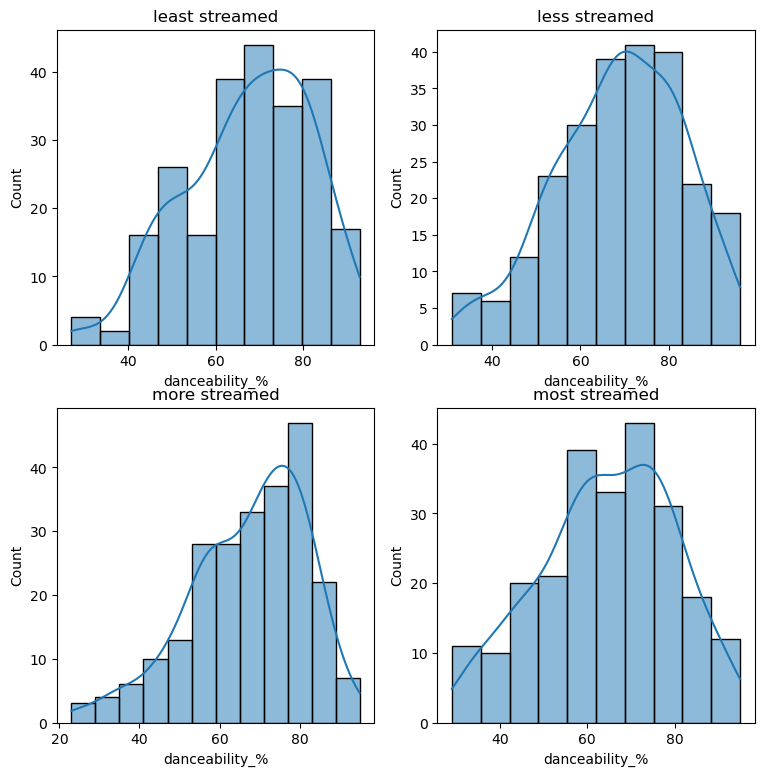

In [272]:
# график danceability
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

sns.histplot(data1['danceability_%'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('least streamed')

sns.histplot(data2['danceability_%'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('less streamed')

sns.histplot(data3['danceability_%'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('more streamed')

sns.histplot(data4['danceability_%'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('most streamed')

plt.show()

__Для второй гипотезы:__

In [148]:
liveness1 = data1['liveness_%']
liveness2 = data2['liveness_%']
liveness3 = data3['liveness_%']
liveness4 = data4['liveness_%']

Оценка разницы между группами: 0.9225287114845938
Доверительный интервал: [-1.76060924  3.57584034]


In [165]:
diff_mean, conf_interval = bootstrap_diff(liveness1, liveness2)
print("Оценка разницы между группами 1 и 2:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')

diff_mean, conf_interval = bootstrap_diff(liveness2, liveness3)
print("Оценка разницы между группами 2 и 3:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')

diff_mean, conf_interval = bootstrap_diff(liveness3, liveness4)
print("Оценка разницы между группами 3 и 4:", diff_mean)
print("Доверительный интервал:", conf_interval, end = '\n\n')

diff_mean, conf_interval = bootstrap_diff(liveness1, liveness4)
print("Оценка разницы между группами 1 и 4:", diff_mean)
print("Доверительный интервал:", conf_interval)

Оценка разницы между группами 1 и 2: 0.6313067226890756
Доверительный интервал: [-2.06334034  3.35745798]

Оценка разницы между группами 2 и 3: 0.7970210084033613
Доверительный интервал: [-1.72310924  3.33004202]

Оценка разницы между группами 3 и 4: 0.1503613445378151
Доверительный интервал: [-2.19821429  2.54212185]

Оценка разницы между группами 1 и 4: 1.5907815126050417
Доверительный интервал: [-0.77384454  3.93771008]


__Вывод:__ с увеличением популярности процентное соотношение живого исполнения в песне понемногу увеличивается, причем в двух самых популярных группах песен оно практически не различается. 

__Гипотеза:__ Пользователи больше слушают песни с высоким процентным соотношением живого выступления в песне. 

## Regression

In [ ]:
import statsmodels.api as sm

__Построим модель с целевой переменной - количеством стримов песни.__

Попробуем взять в большей части субъективные значения за регрессоры (кроме значения beats per minute).

Регрессоры в первой спецификации: Количество речи в песне, количество элементов живого выступления, количество битов в минуту, инструментальность, позитивность.

In [290]:
X = df[['speechiness_%', 'liveness_%', 'bpm', 'instrumentalness_%', 'valence_%']]
y = df['streams']


# Добавление колонки с единицами для свободного члена
X = sm.add_constant(X)

# Оценка модели линейной регрессии
model = sm.OLS(y, X).fit()

# Вывод отчета модели
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.920
Date:                Mon, 25 Mar 2024   Prob (F-statistic):            0.00160
Time:                        21:26:47   Log-Likelihood:                -20529.
No. Observations:                 952   AIC:                         4.107e+04
Df Residuals:                     946   BIC:                         4.110e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               6.729e+08   9.43

In [237]:
# тест на гетероскедастичность Белферрони-Кандера

from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value_het, _, _ = het_breuschpagan(model.resid, model.model.exog)
print('p-value of breuschpagan is', p_value_het)

p-value of breuschpagan is 0.08226804250935231


p-значение больше уровня значимости, значит принимается гипотеза об отсутствии гетероскедастичности в модели. 

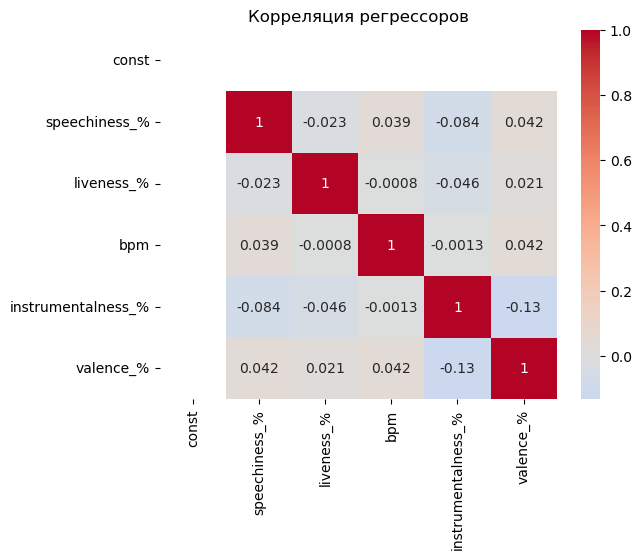

In [265]:
# визуальный тест на мультиколлинеарность

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция регрессоров')
plt.show()

Наблюдается одинаковая корреляция между speechiness_%, bpm и valence_%. Модуль корреляции небольшой, но это может ухудшать качество модели, так как другие корреляции сравнительно маленькие по модулю. 

__Новая спецификация модели:__ убираем регрессор "bpm" и заменяем его на 'in_spotify_charts'. Возможно, более точный и отвечающий популярности песни показатель улучшит модель. Также удаляем сколеллированный с другими показатель 'speechiness_%'. 

In [291]:
X_new = df[['liveness_%', 'instrumentalness_%', 'valence_%', 'in_spotify_charts']]
y_new = df['streams']

# Добавление колонки с единицами для свободного члена
X_new = sm.add_constant(X_new)

# Оценка модели линейной регрессии
model_new = sm.OLS(y_new, X_new).fit()

# Вывод отчета модели
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.137
Date:                Mon, 25 Mar 2024   Prob (F-statistic):             0.0939
Time:                        21:28:46   Log-Likelihood:                -20535.
No. Observations:                 952   AIC:                         4.108e+04
Df Residuals:                     948   BIC:                         4.110e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               6.155e+08    5.1

In [285]:
# тест на гетероскедастичность Белферрони-Кандера

from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value_het, _, _ = het_breuschpagan(model_new.resid, model_new.model.exog)
print('p-value of breuschpagan is', p_value_het)

p-value of breuschpagan is 4.007454624661497e-08


p-значение меньше уровня значимости, значит отвергается гипотеза об отсутствии гетероскедастичности в модели. 

__Исправляем гетероскедастичность, используя гетероскедастично-устойчивые стандартные ошибки (HC1).__


In [289]:
robust_results = model_new.get_robustcov_results(cov_type='HC1')
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                streams   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     9.326
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           2.15e-07
Time:                        21:24:00   Log-Likelihood:                -20506.
No. Observations:                 952   AIC:                         4.102e+04
Df Residuals:                     947   BIC:                         4.105e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.319e+08   4.75e+07     11.195      0.000    4.39e+08    6.25e+08
liveness_%         -1.563e+06   1.11e+06     -1.406      0.160   -3.74e+06    6.19e+05
instrumentalness_% -3.471e+06   1.13e+06     -3.065      0.002   -5.69e+06   -1.25e+06
valence_%          -1.346e+06   7.78e+05     -1.730      0.084   -2.87e+06    1.81e+05
in_spotify_charts   7.107e+06   1.36e+06      5.220      0.000    4.44e+06    9.78e+06
==============================================================================
Omnibus:                      349.351   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1152.653
Skew:                           1.808   Prob(JB):                    5.06e-251
Kurtosis:                       6.997   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Изменилась статистическая значимость регрессоров, при этом понизилась F-statistic. 

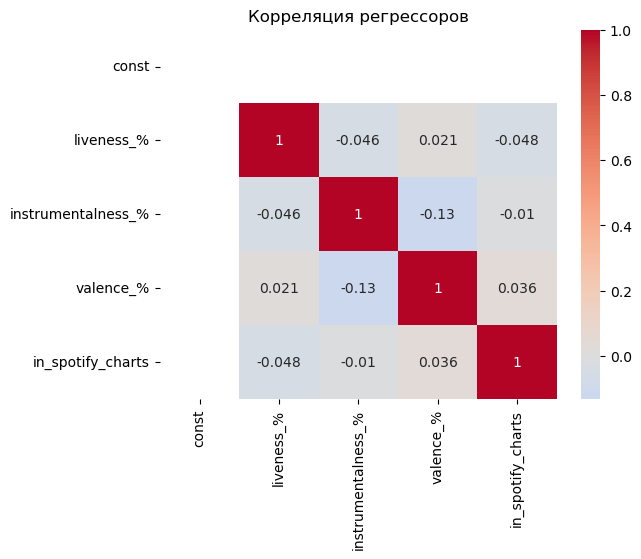

In [286]:
# визуальный тест на мультиколлинеарность

corr_matrix_new = X_new.corr()
sns.heatmap(corr_matrix_new, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция регрессоров')
plt.show()

В обоих моделях очень маленький R-squared, и F-statistic. Регрессия не очень хорошо объясняет исходные данные.
Чтобы достичь цели исследования, выбор был сделан в сторону модели с только субъективными показателями, слабо коррелирующими между собой. 

Выбор сделан в пользу второй модели. В ней выше значение R-squared, значит она слегка лучше объясняет данные. Также в нее включен регрессор количества появления песни в чартах, что, возможно позволяет лучше объяснить высокие стримы песни, так как пользовтели могут пользоваться чартами для поиска новой и популярной музыки. 

__ВЫВОД:__ Использование исключительно субъективных показателей в модели, оценивающей популярность музыки. Для лучшего объяснения высоких стриминговых показателей следует включать и "бизнесовые" переменные в качестве регрессоров. 